# Univariate LSTM - MVO Optimized Portfolio Construction
Some helpful resources

[Multi stock prediction w single nn](https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn),
[LSTM math](https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235)
## 1. Import Libraries

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.optimize as sco

plt.style.use('seaborn-darkgrid')
%matplotlib inline


### Gather LSTM values for MVO 

In [2]:
%store -r IVV_pred_df
%store -r SHY_pred_df
%store -r VNQ_pred_df
%store -r GLD_pred_df
%store -r LSTM_df
%store -r LSTM_pct
%store -r LSTM_norm

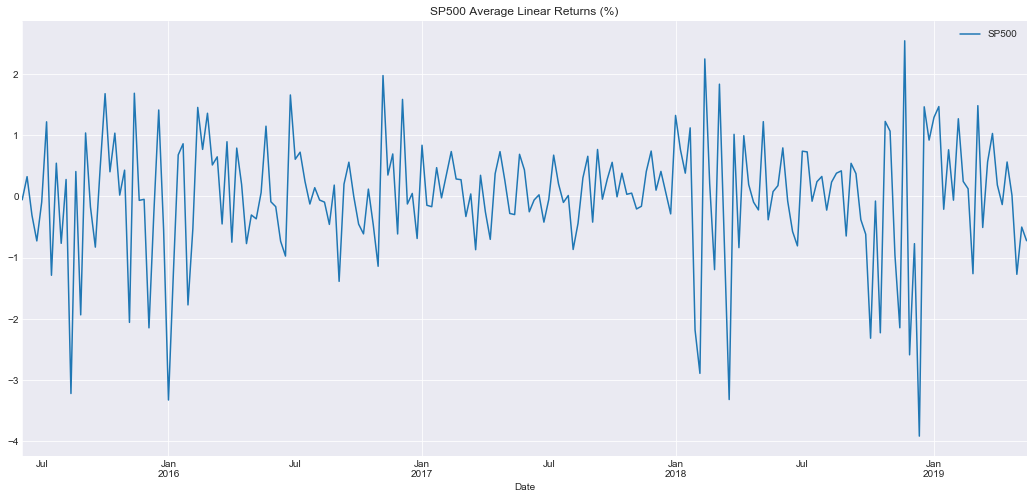

In [3]:
#Visualize SP500 Log returns (use SP500)
LSTM_norm.SP500.plot(figsize=(18, 8))
plt.title("SP500 Average Linear Returns (%)")
plt.grid(True);
plt.legend()
plt.show()

In [4]:
LSTM_pred = LSTM_df.drop(['SP500'],axis=1)
LSTM_pred.head(2)

,IVV_LSTM,SHY_LSTM,VNQ_LSTM,GLD_LSTM
Date,,,,
2015-06-01,177.103226,177.925018,166.597473,112.879906
2015-06-08,177.260620,178.397751,166.965073,113.796295


### Break portfolio into per-period (annually)

In [12]:
period1 = '2016-06-01'
period2 = '2017-06-01'
period3 = '2018-06-01'
period4 = '2019-06-01'
data_period1 = LSTM_pred[LSTM_pred.index<period1]
data_period2 = LSTM_pred[LSTM_pred.index<period2]
data_period3 = LSTM_pred[LSTM_pred.index<period3]
data_period4 = LSTM_pred[LSTM_pred.index<period4]

### Efficacy of Portfolio Theory
Calculate realized log returns, std, covariance, correlations for all assets' observations.
Construction and method follows [Bradford Lynch's blog post](http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html) and [this](https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb).
* Math of MPT https://docs.mosek.com/9.0/pythonfusion/case-studies-portfolio.html

#### Mean 
#### Mean of return (of single asset) = expected return r over n observations
Take the log of the weighted-average of individual asset return 
\begin{equation*}
Mean(returns) = \frac{1}{n}\sum_{i=1}^n r_i
\end{equation*}

#### Variance (aka. Volatility)
Measures how volatile the return of each asset is individually.
\begin{equation*}
Var(returns) = \sum_{i=1}^n (r_i - μ)^2
\end{equation*}

#### Annualize
To annualize weekly data, k = sqrt(52) is used.

#### Monte-Carlo simulation on weights
"" To see all the possible combinations of 4 asset weights. With each random set of weights, our simulation will calculate a new annual return and standard deviation for the portfolio.

Start by making 2 empty lists called 'portfolio returns (pf_ret)' and 'portfolio volatilities (pf_vol)'. These will capture all simulation calculations of the for function beneath it.

Then add in my random weights generator code from earlier and have 1000 interations of random weights plug into our portfolio return and portfolio volatility formulas. The append method is what creates a new entry to the list with each interation. ""
#### Portfolio mean variance calculations
\begin{equation*}
Mean(Portfolio Returns) = \sum_{i=1}^n (w_ir_i)
\end{equation*}

\begin{equation*}
Var(Portfolio Returns) = \sum_{i=1}^n \sum_{j=1}^n w_iw_jρ_i,_jσ_iσ_j = \mathbf{w^T⋅(cov⋅w)}
\end{equation*}


### Data visualization

In [5]:
# how assets correlate with one another
LSTM_pred.corr()

,IVV_LSTM,SHY_LSTM,VNQ_LSTM,GLD_LSTM
IVV_LSTM,1.000000,0.607518,0.726831,0.403891
SHY_LSTM,0.607518,1.000000,0.812463,0.435396
VNQ_LSTM,0.726831,0.812463,1.000000,0.536121
GLD_LSTM,0.403891,0.435396,0.536121,1.000000


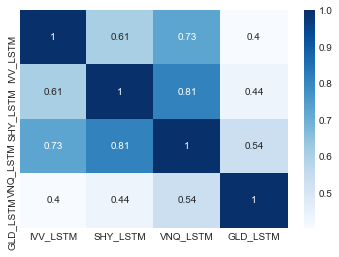

In [6]:
sns.heatmap(LSTM_pred.corr(), annot=True, cmap="Blues");

### Functions
2015 - 2019 predictions

In [7]:
def portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix):
    returns = np.sum(weighted_avg_ret*weights ) *52
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52)
    #sharpe = (portfolio_return - rf) / portfolio_std_dev
    return std, returns

In [8]:
def random_portfolios(runs, weighted_avg_ret, cov_matrix, rf):
    results = np.zeros((3,runs))
    weights_record = []
    for i in range(runs):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - rf) / portfolio_std_dev
    return results, weights_record

In [9]:
returns = LSTM_pred.pct_change()
weighted_avg_ret = returns.mean()
cov_matrix = returns.cov()
runs = 50000
#according to the Federal Deposit Insurance Corporation,
#the average bank interest rate is 0.09%.
#However, T-Bill and T-Bond can also be consideres as a form of risk free investment
#therefore, 0.01 is a middle value. 
rf = 0.01

In [10]:
def display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf):
    results, weights = random_portfolios(runs,weighted_avg_ret, cov_matrix, rf)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=LSTM_pred.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=LSTM_pred.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    

In [11]:
display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.06


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     37.43     61.79      0.31      0.47
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.06


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     30.78     51.26      1.87     16.08


#### 2015-2016 prediction

In [14]:
returns = data_period1.pct_change()
weighted_avg_ret = returns.mean()
cov_matrix = returns.cov()
runs = 50000
#according to the Federal Deposit Insurance Corporation,
#the average bank interest rate is 0.09%.
#However, T-Bill and T-Bond can also be consideres as a form of risk free investment
#therefore, 0.01 is a middle value. 
rf = 0.01

In [15]:
def portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix):
    returns = np.sum(weighted_avg_ret*weights ) *52
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52)
    #sharpe = (portfolio_return - rf) / portfolio_std_dev
    return std, returns

In [16]:
def random_portfolios(runs, weighted_avg_ret, cov_matrix, rf):
    results = np.zeros((3,runs))
    weights_record = []
    for i in range(runs):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - rf) / portfolio_std_dev
    return results, weights_record

In [17]:
def display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf):
    results, weights = random_portfolios(runs,weighted_avg_ret, cov_matrix, rf)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data_period1.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data_period1.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    

In [18]:
display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.07


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation      0.83     63.92     33.06      2.19
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.06
Annualised Volatility: 0.05


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     33.15     60.48       0.1      6.27


#### 2015 - 2017 prediction

In [19]:
returns = data_period2.pct_change()
weighted_avg_ret = returns.mean()
cov_matrix = returns.cov()
runs = 50000
#according to the Federal Deposit Insurance Corporation,
#the average bank interest rate is 0.09%.
#However, T-Bill and T-Bond can also be consideres as a form of risk free investment
#therefore, 0.01 is a middle value. 
rf = 0.01

In [20]:
def portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix):
    returns = np.sum(weighted_avg_ret*weights ) *52
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52)
    #sharpe = (portfolio_return - rf) / portfolio_std_dev
    return std, returns

In [21]:
def random_portfolios(runs, weighted_avg_ret, cov_matrix, rf):
    results = np.zeros((3,runs))
    weights_record = []
    for i in range(runs):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - rf) / portfolio_std_dev
    return results, weights_record

In [22]:
def display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf):
    results, weights = random_portfolios(runs,weighted_avg_ret, cov_matrix, rf)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data_period2.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data_period2.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    

In [23]:
display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.05


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     47.95     51.18      0.39      0.49
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.05


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     41.32     56.11      0.02      2.55


#### 2015-2018

In [29]:
returns = data_period3.pct_change()
weighted_avg_ret = returns.mean()
cov_matrix = returns.cov()
runs = 50000
#according to the Federal Deposit Insurance Corporation,
#the average bank interest rate is 0.09%.
#However, T-Bill and T-Bond can also be consideres as a form of risk free investment
#therefore, 0.01 is a middle value. 
rf = 0.01

In [30]:
def portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix):
    returns = np.sum(weighted_avg_ret*weights ) *52
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52)
    #sharpe = (portfolio_return - rf) / portfolio_std_dev
    return std, returns

In [31]:
def random_portfolios(runs, weighted_avg_ret, cov_matrix, rf):
    results = np.zeros((3,runs))
    weights_record = []
    for i in range(runs):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - rf) / portfolio_std_dev
    return results, weights_record

In [32]:
def display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf):
    results, weights = random_portfolios(runs,weighted_avg_ret, cov_matrix, rf)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data_period3.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data_period3.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    

In [33]:
display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.07


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     56.53     37.42      0.08      5.97
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.06
Annualised Volatility: 0.05


            IVV_LSTM  SHY_LSTM  VNQ_LSTM  GLD_LSTM
allocation     34.92     61.82      0.31      2.96


## Rolling Sharpe

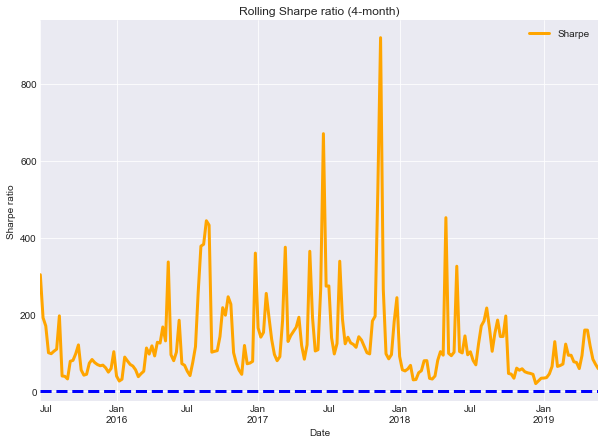

---------------------------------------------------------------
In case you want to check the result data

             Adj_Close  rolling_SR
Date                              
2019-04-29  294.202942  159.659629
2019-05-06  288.229645  118.262360
2019-05-13  286.142456   83.992907
2019-05-20  283.021637   70.488315
2019-05-27  275.607147   59.179270


In [52]:


ivv['rolling_SR'] = ivv.Adj_Close.rolling(4).apply(lambda x: (x.mean() - 0.01) / x.std(), raw = True)
ivv.fillna(0, inplace = True)
ivv[ivv['rolling_SR'] > 0].rolling_SR.plot(style='-', lw=3, color='orange', 
                                         label='Sharpe', figsize = (10,7))\
                                         .axhline(y = 1.6, color = "blue", lw = 3,
                                                 linestyle = '--')

plt.ylabel('Sharpe ratio')
plt.legend(loc='best')
plt.title('Rolling Sharpe ratio (4-month)')
plt.show()

print('---------------------------------------------------------------')
print('In case you want to check the result data\n')
print(ivv.tail()) # I use tail, beacause of the size of your window.

## Realized MVO

In [26]:
def get_data(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'_2015.csv', usecols=['Date','Adj Close'], parse_dates=True, index_col='Date' ).astype('float32').dropna()


In [49]:
ivv = get_data('IVV')
shy = get_data('SHY')
vnq = get_data('VNQ')
gld = get_data('GLD')

,Adj_Close
Date,
2015-06-01,193.431183
2015-06-08,193.632721
2015-06-15,194.951645
2015-06-22,193.412872
2015-06-29,192.107697
2015-07-06,192.291885
2015-07-13,196.887589
2015-07-20,192.715515
2015-07-27,195.027222


In [30]:
actual_table = pd.concat([ivv,shy,vnq,gld],axis=1)

In [32]:
actual_table.columns = ['IVV','SHY','VNQ','GLD']

In [34]:
def portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix):
    returns_actual = np.sum(weighted_avg_ret*weights ) *52
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52)
    #sharpe = (portfolio_return - rf) / portfolio_std_dev
    return std, returns_actual

In [35]:
def random_portfolios(runs, weighted_avg_ret, cov_matrix, rf):
    results = np.zeros((3,runs))
    weights_record = []
    for i in range(runs):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, weighted_avg_ret, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - rf) / portfolio_std_dev
    return results, weights_record

In [36]:
returns_actual = actual_table.pct_change()
weighted_avg_ret = returns_actual.mean()
cov_matrix = returns_actual.cov()
runs = 50000
#according to the Federal Deposit Insurance Corporation,
#the average bank interest rate is 0.09%.
#However, T-Bill and T-Bond can also be consideres as a form of risk free investment
#therefore, 0.01 is a middle value. 
rf = 0.01

In [37]:
def display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf):
    results, weights = random_portfolios(runs,weighted_avg_ret, cov_matrix, rf)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=actual_table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=actual_table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='plasma', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.03
Annualised Volatility: 0.03


              IVV    SHY   VNQ   GLD
allocation  18.38  73.91  1.65  6.06
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.01


             IVV    SHY   VNQ   GLD
allocation  7.99  90.15  0.44  1.42


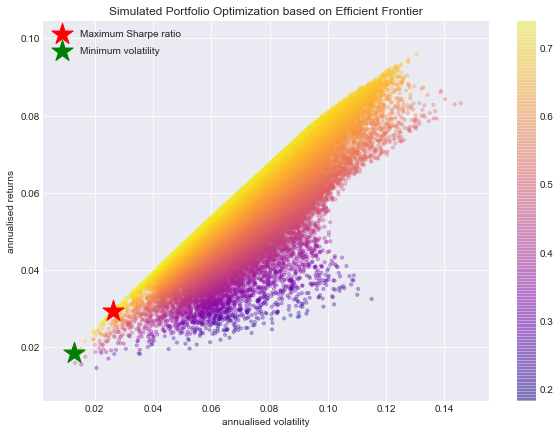

In [38]:
display_simulated_ef_with_random(weighted_avg_ret, cov_matrix, runs, rf)

### Plot total portfolio value v SP500